# DE-9IM Relationships

[DE-9IM](https://en.wikipedia.org/wiki/DE-9IM)


## Setup

### Imports

In [1]:
# Shared Packages
import pandas as pd

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from metrics import *
from relations import *

### Global Settings

In [2]:
PRECISION = 2

In [3]:
%matplotlib inline

The DE-9IM model is based on a 3×3 intersection matrix with the form:

![DE-9IM Matrix](<Images/DE9IM equations.png>)

where 
_dim_ is the dimension of the intersection (∩) of the interior (I), boundary (B), and exterior (E) of geometries a and b.

Visually, for two overlapping polygonal geometries, the result of the function DE_9IM(a,b) looks like:


![DE_9IM Example](./Images/DE-9IM.png)

This matrix can be serialized. Reading from left-to-right and top-to-bottom, the result is

![DE9IM Linearized](<Images/linearized matrix.png>)

 So, in a compact representation as string code is '212101212'.


The relationship string is converted to binary format, where 'F'
is '0' and '1' or '2' is '1'.

Args:
    poly_a (shapely.MultiPolygon): All contours for a structure on
        a single slice.
    poly_b (shapely.MultiPolygon): All contours for a second
        structure on the same slice.
    relation_str (str): The DE-9IM relationship string for the two

Attributes:
    str (str): A length 9 string of the DE-9IM relationship consisting of
        'F', '1', or '2'.
    relation (str): The relationship string converted to binary format,
        where 'F' becomes '0', and '1' or '2' becomes '1'.

Methods:
    to_int (shift=0): Returns the relationship string converted to an
        integer.  The shift argument shifts the binary equivalent the
        given number of places to the left.

In [4]:
class DE9IM():
    '''The DE-9IM relationship string for two polygons.
    '''
    def __init__(self,
                 poly_a: shapely.MultiPolygon = None,
                 poly_b: shapely.MultiPolygon = None,
                 relation_str: str = None):
        if (poly_a is not None) & (poly_a is not None):
            self.relation_str = shapely.relate(poly_a, poly_b)
        elif relation_str is not None:
            self.relation_str = relation_str
        else:
            raise ValueError(''.join([
                'Must supply either polygons or a relationship string to ',
                'create a DE9IM object.'
                ]))
        # Convert relationship string in the form '212FF1FF2' into a
        # boolean string.
        self.relation = self.to_bool()
        self.int = self.to_int()

    def to_bool(self):
        relation = self.relation_str.replace('F','0').replace('2','1')
        return relation

    def to_int(self, shift=0):
        shift_factor = 2**shift
        binary_relation = int(self.relation, base=2) * shift_factor
        return binary_relation

    def boundary_adjustment(self, boundary_type: str)->'DE9IM':
        '''Adjust the DE-9IM relationship matrix of a boundary slice.
        '''
        new_str_list = []
        if boundary_type == 'a':
            interiors = self.relation_str[0:3]
            boundaries = self.relation_str[3:6]
            exteriors = self.relation_str[6:9]
            new_str_list.extend(['F', 'F', 'F'])
            for i, b in zip(interiors, boundaries):
                if i == 'F':
                    new_str_list.append(b)
                else:
                    new_str_list.append(i)
            new_str_list.extend(exteriors)
        elif boundary_type == 'b':
            interiors = self.relation_str[0:9:3]
            boundaries = self.relation_str[1:9:3]
            exteriors = self.relation_str[2:9:3]
            for i, b, e in zip(interiors, boundaries, exteriors):
                new_str_list.append('F')
                if i == 'F':
                    new_str_list.append(b)
                else:
                    new_str_list.append(i)
                new_str_list.append(e)
        else:
            raise ValueError(f'Invalid boundary type: {boundary_type}')
        new_str = ''.join(new_str_list)
        return self.__class__(relation_str=new_str)

    def transpose(self)->'DE9IM':
        '''Transpose the DE-9IM relationship matrix.
        '''
        # Select every third character from the string.
        interiors = self.relation_str[0:9:3]
        boundaries = self.relation_str[1:9:3]
        exteriors = self.relation_str[2:9:3]
        new_str_list = interiors + boundaries + exteriors
        new_str = ''.join(new_str_list)
        return self.__class__(relation_str=new_str)

    def __repr__(self):
        return f'<DE9IM>: {self.relation_str}'

    def __str__(self):
        bin_str = self.relation
        if len(bin_str) < 9:
            zero_pad = 9 - len(bin_str)
            bin_str = '0' * zero_pad + bin_str[2:]
        bin_fmt = '|{bin1}|\n|{bin2}|\n|{bin3}|'
        bin_dict = {'bin1': bin_str[0:3],
                    'bin2': bin_str[3:6],
                    'bin3': bin_str[6:9]}
        return bin_fmt.format(**bin_dict)


In [5]:
box6 = shapely.MultiPolygon([shapely.Polygon(box_points(6))])
box6
box4 = shapely.MultiPolygon([shapely.Polygon(box_points(4))])
r = DE9IM(box6, box4)
r

<DE9IM>: 212FF1FF2

In [6]:
r.int

457

In [7]:
print(str(r))

|111|
|001|
|001|


In [8]:
b = r.boundary_adjustment('a')
print(str(b))
b

|000|
|111|
|001|


<DE9IM>: FFF212FF2

In [9]:
b = r.boundary_adjustment('b')
print(str(b))
b

|011|
|001|
|001|


<DE9IM>: F22FF1FF2

In [10]:
b = r.transpose()
print(str(b))
b

|100|
|100|
|111|


<DE9IM>: 2FF1FF212


When written in binary, the 27 bit relationship contains 3 9-bit
parts corresponding to DE-9IM relationships. The left-most 9 bits
are the relationship between the second structure's contour and the
first structure's convex hull polygon. The middle 9 bits are the
relationship between the second structure's contour and the first
structure's exterior polygon (i.e. with any holes filled). The
right-most 9 bits are the relationship between the second
structure's contour and the first structure's contour.

Args:
    slice_structures (pd.DataFrame): A table of structures, where
        the values are the contours with type StructureSlice. The
        column index contains the roi numbers for the structures.
        The row index contains the slice index distances.

Returns:
    DE9IM_Type: An integer corresponding to a 27 bit binary value
        reflecting the combined DE-9IM relationship between contour2 and
        contour1's convex hull, exterior and polygon.

In [11]:
class DE27IM():
    '''The DE-9IM relationships string for two contours, their exteriors, and
    the corresponding convex hull.
    '''
    def __init__(self, contour_a: StructureSlice = None,
                 contour_b: StructureSlice = None,
                 relation_str: str = None,
                 relation_int: int = None):
        if (contour_a is not None) & (contour_b is not None):
            relation = self.relate_contours(contour_a, contour_b)
        elif relation_str is not None:
            self.relation = relation_str
            self.int = self.to_int(relation_str)
        elif relation_int is not None:
            self.int = relation
            self.relation = self.to_str(relation_int)
        else:
            raise ValueError(''.join([
                'Must supply either StructureSlices or a relationship string ',
                'to create a DE27IM object.'
                ]))
        self.relation = self.to_bool()
        self.int = int(self.relation, base=2)

    @staticmethod
    def to_str(relation_int: int)->str:
        bin_str = bin(relation_int)
        if len(bin_str) < 29:
            zero_pad = 29 - len(bin_str)
            bin_str = '0' * zero_pad + bin_str[2:]
        elif len(bin_str) > 29:
            raise ValueError(''.join([
                'The input integer must be 27 bits long. The input integer ',
                'was: ', str(relation_int)
                ]))
        else:
            bin_str = bin_str[2:]
        return bin_str

    @staticmethod
    def to_int(relation_str: str)->int:
        try:
            relation_int = int(relation_str, base=2)
        except ValueError as err:
            raise ValueError(''.join([
                'The input string must be a 27 bit binary string. The input ',
                'string was: ', relation_str
                ])) from err
        return relation_int

    def relate_contours(self,
                        contour_a: StructureSlice,
                        contour_b: StructureSlice)->DE27IM_Type:
        '''Get the 27 bit relationship for two structures on a given slice.
        '''
        contour = DE9IM(contour_a.contour, contour_b.contour)
        external = DE9IM(contour_a.exterior, contour_b.contour)
        convex_hull = DE9IM(contour_a.hull, contour_b.contour)

        # Convert the DE-9IM relationships into a DE-27IM relationship string.
        full_relation = ''.join([contour, external, convex_hull])
        relation_str = full_relation.replace('F','0').replace('2','1')

        self.to_bool()
        return full_relation

    def merge(self, other: Union['DE27IM', int])->int:
        '''Combine two DE27IM relationships.

        Returns:
            int: An integer corresponding to a 27 bit binary value
                reflecting the combined relationships.
        '''
        if isinstance(other, DE27IM):
            other_rel = other.int
        elif isinstance(other, int):
            other_rel = other
        else:
            raise ValueError(''.join([
                'Must supply either a DE27IM object or an integer to merge ',
                'relationships.'
                ]))
        merged_rel = self.int | other_rel
        return merged_rel

    def bin_format(self):
        bin_str = self.relation
        if len(bin_str) < 29:
            zero_pad = 29 - len(bin_str)
            bin_str = bin_str[0:2] + '0' * zero_pad + bin_str[2:]
        bin_dict = {}
        bin_fmt = '|{bin#}|_'
        bin_list = []
        for idx in range(9):
            row_num = idx % 3
            col_num = idx // 3
            index = row_num * 3 + col_num
            bin_dict[f'bin{index}'] = bin_str[idx*3:(idx+1)*3]
            bin_ref = bin_fmt.replace('#', str(index))
            if col_num == 2:
                bin_ref = bin_ref.replace('_', '\n')
            else:
                bin_ref = bin_ref.replace('_', '\t')
            bin_list.append(bin_ref)
        return ''.join(bin_list).format(**bin_dict)

    def __repr__(self):
        return f'<DE27IM>: {self.relation_str}'


# Done To Here

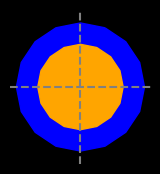

Relationship: Unknown


In [12]:
def contains_example1():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    a = StructureSlice([circle6])
    b = StructureSlice([circle4])
    return a, b

a, b = contains_example1()
ax = plot_ab(a.contour, b.contour)

print(identify_relation(relate_contours(a, b)))

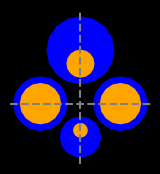

Relationship: Unknown


In [13]:
def contains_example6():
    circle4_left = shapely.Polygon(circle_points(2, offset_x=-3))
    circle4_right = shapely.Polygon(circle_points(2, offset_x=3))
    circle3_left = shapely.Polygon(circle_points(1.5, offset_x=-3))
    circle3_right = shapely.Polygon(circle_points(1.5, offset_x=3))
    circle5_up = shapely.Polygon(circle_points(2.5, offset_y=4))
    circle2_up = shapely.Polygon(circle_points(1, offset_y=3))
    circle3_down = shapely.Polygon(circle_points(1.5, offset_y=-2.5))
    circle1_down = shapely.Polygon(circle_points(0.5, offset_y=-2))
    a = StructureSlice([circle4_left, circle4_right, circle5_up, circle3_down])
    b = StructureSlice([circle3_left, circle3_right, circle2_up, circle1_down])
    return a, b

a, b = contains_example6()
ax = plot_ab(a.contour, b.contour)

print(identify_relation(relate_contours(a, b)))

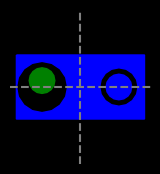

Relationship: Unknown


In [14]:
def surrounds_example3():
    box10x5 = shapely.Polygon(box_points(10,5))
    circle4_left = shapely.Polygon(circle_points(2, offset_x=-3))
    circle3_right = shapely.Polygon(circle_points(1.5, offset_x=3))
    circle2_left = shapely.Polygon(circle_points(1, offset_x=-3, offset_y=0.5))
    circle2_right = shapely.Polygon(circle_points(1, offset_x=3))
    a = StructureSlice([box10x5, circle4_left, circle3_right, circle2_right])
    b = StructureSlice([circle2_left])
    return a, b

a, b = surrounds_example3()
ax = plot_ab(a.contour, b.contour)

print(identify_relation(relate_contours(a, b)))

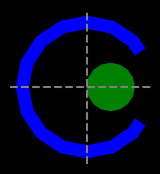

Relationship: Unknown


In [15]:
def shelters_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle5 = shapely.Polygon(circle_points(2.5))
    circle4_offset = shapely.Polygon(circle_points(2, offset_x=3.5))
    shell = shapely.difference(circle6, circle5)
    cove = shapely.difference(shell, circle4_offset)
    circle2 = shapely.Polygon(circle_points(1, offset_x=1))

    a = StructureSlice([cove])
    b = StructureSlice([circle2])
    return a, b

a, b = shelters_example()
ax = plot_ab(a.contour, b.contour)

print(identify_relation(relate_contours(a, b)))